In [1]:
import sys

sys.path.append('./source/')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import integrate, stats
import matplotlib.cm as cm
from numpy import fft
from scipy import interpolate as intp
import importlib
import healpy

from source import plots
from source import prob_dists as pd
from utils import read_param_file, update_params, configure_plot_params

configure_plot_params(fontsize=12)

In [3]:
param_file = './source/n0.params'
params = read_param_file(param_file)
p = params

# exposure = 5 * 14000 / (4 * np.pi)
# p = update_params(param_file, p, 'exposure', exposure)

# phipp = 7.12073e-30
# fwimp = phipp * 8 * np.pi / 1e-28
# # fwimp = 1e-4
# p = update_params(param_file, p, 'fwimp', fwimp)

# p = update_params(param_file, p, 'bg', 1)
# p = update_params(param_file, p, 'beg', 1)

# print(exposure, fwimp)
p

{'R_G': 220,
 'd_solar': 8.5,
 'psi': 40,
 'M_min': 0.01,
 'M_max': 10000000000.0,
 'fwimp': 1.7896346444957159,
 'mean_params': {'a': 77.4, 'b': 0.87, 'c': -0.23},
 'nside': 128,
 'area_fermi': 2000.0,
 'n': 0,
 'log_flux_min': -15,
 'log_flux_max': -5,
 'N': 2000,
 'log_k_min': -3,
 'log_k_max': 6,
 'N_k': 250000,
 'psh_log_f_min': -6,
 'psh_log_f_max': -3.0,
 'N_psh': 1000,
 'omega_pixel': 6.391586616190171e-05,
 'exposure': 5570.423008216337,
 'iso_flux_bg': 0.0008939106670451649,
 'gal_flux_bg_file': './output/gal_flux_bg.npy',
 'bg': 1,
 'beg': 1,
 'beta': 1.9}

In [4]:
nside = p['nside']
npix = healpy.nside2npix(nside)
lon, lat = healpy.pix2ang(nside, range(npix), lonlat=True)
ang_dists = np.rad2deg(np.arccos(np.cos(np.deg2rad(lon)) * np.cos(np.deg2rad(lat))))
good_indices = (abs(lat) >= 40)

In [5]:
## S-WAVE
s_psh, s_pshfunc2d, s_fluxes, _ = pd.psh_s(ang_dists[good_indices], return_all=True)
s_psh = s_psh[::3]
s_fluxes = s_fluxes[::3]

## SOM
som_psh, som_pshfunc2d, som_fluxes, _= pd.psh_som(ang_dists[good_indices], return_all=True)
som_psh = som_psh[::3]
som_fluxes = som_fluxes[::3]

In [6]:
# search parameters
num_search = 100
p['fwimp'] *= 1

fwimps = np.logspace(np.log10(p['fwimp'])-.5, np.log10(p['fwimp'])+.5, num_search)
begs = np.linspace(.95, 1.05, num=100)

exposure_search = np.logspace(0, 1, num=1) * p['exposure']
exposure_search = np.array([1]) * p['exposure']

In [7]:
 def likelihood_run_for_model_2d(p, psh, fluxes, poisson_rescale=1, model=''):
    # run likelihoods
    s_S = np.zeros((len(exposure_search), len(begs), num_search))
    som_S = np.zeros((len(exposure_search), len(begs), num_search))
    poisson_S = np.zeros((len(exposure_search), len(begs), num_search))

    for i, exposure in enumerate(exposure_search):
        p['exposure'] = exposure
        p['bg'] = 1

        gal_bg = np.load(p['gal_flux_bg_file'])[good_indices] * p['exposure'] * p['bg']
        iso_bg = p['iso_flux_bg'] * p['exposure'] * p['beg']
        bg_count = gal_bg + iso_bg

        counts = np.arange(0, bg_count.max() + 9 * np.sqrt(bg_count.max()) + p['exposure'] * p['fwimp'] * fluxes.max() + 9 * np.sqrt(p['exposure'] * p['fwimp'] * fluxes.max()))

        print('calculating pc to count =', counts[-1])

        unique_ang, uni_ind, uni_inv = np.unique(np.abs(ang_dists[good_indices]), return_inverse=True, return_index=True)

        pshdat = psh[:, uni_ind]
        psh = pshdat[:, uni_inv]
        if model == 's':
            spsh = pshdat[:, uni_inv]
            sompsh = som_psh
        elif model == 'som':
            sompsh = pshdat[:, uni_inv]
            spsh = s_psh
        else:
            spsh = s_psh
            sompsh = som_psh

        pc_psi = integrate.simps(pshdat[..., np.newaxis] * stats.poisson.pmf(counts[np.newaxis, np.newaxis, :], p['exposure'] * p['fwimp'] * fluxes[:, np.newaxis, np.newaxis]), fluxes, axis=0)
        pc_psi /= np.sum(pc_psi, axis=-1)[:, np.newaxis]

        print('is pc norm', np.allclose(np.sum(pc_psi, axis=-1), 1))
        print('last pc prob', pc_psi[:, -1])

        pc_of_psi = pc_psi[uni_inv]

        # generate sky map
        subcounts = pd.generate_skymap_sample_pc(p, pc_of_psi, ang_dists[good_indices], good_indices, return_subcounts=True, save_output=True, bg_counts=bg_count)
        p['bg'] = 0.97
        
        gal_bg = np.load(p['gal_flux_bg_file'])[good_indices] * p['exposure'] * p['bg']
        iso_bg = p['iso_flux_bg'] * p['exposure'] * p['beg']
        bg_count = gal_bg + iso_bg

        print('generated skymap with', p['fwimp'])
        print('max counts', counts[-1], subcounts.max())

        for j, beg in enumerate(begs):
            for k, fwimp in enumerate(fwimps):
                S = pd.likelihood2d([exposure, beg, fwimp], spsh, subcounts.astype(np.int16), s_fluxes, eg_bg_count=iso_bg, g_bg_count=gal_bg)
                s_S[i, j, k] = S

                S = pd.likelihood2d([exposure, beg, fwimp/100], sompsh, subcounts.astype(np.int16), som_fluxes, eg_bg_count=iso_bg, g_bg_count=gal_bg)
                som_S[i, j, k] = S

                S = pd.poisson_likelihood2d([exposure, beg, fwimp/poisson_rescale], psh, subcounts.astype(np.int16), fluxes, eg_bg_count=iso_bg, g_bg_count=gal_bg)
                poisson_S[i, j, k] = S
            
            print(j+1, '/', len(begs))

        print(i+1, '/', len(exposure_search))
        
#     from scipy.optimize import minimize
    
#     indmax = np.unravel_index(np.argmin(s_S, axis=None), s_S.shape)
    
#     s_max = minimize(pd.likelihood2d, [exposure_search[indmax[0]], begs[indmax[1]], fwimps[indmax[2]]], args=(spsh, subcounts.astype(np.int16), s_fluxes, iso_bg, gal_bg), method='Nelder-Mead')
#     print('swave\t', s_max)
    
#     som_max = minimize(pd.likelihood2d, [exposure_search[indmax[0]], begs[indmax[1]], fwimps[indmax[2]]/100], args=(sompsh, subcounts.astype(np.int16), som_fluxes, iso_bg, gal_bg), method='Nelder-Mead')
#     print('som\t', som_max)
    
#     poi_max = minimize(pd.likelihood2d, [exposure_search[indmax[0]], begs[indmax[1]], fwimps[indmax[2]]/poisson_rescale], args=(psh, subcounts.astype(np.int16), fluxes, iso_bg, gal_bg), method='Nelder-Mead')
#     print('poi\t', poi_max)
    
    return [s_S, som_S, poisson_S]

In [8]:
# SS = []

# SS.append(likelihood_run_for_model_2d(p, s_psh, s_fluxes, model='s'))
# p['fwimp'] /= 100
# SS.append(likelihood_run_for_model_2d(p, som_psh, som_fluxes, model='som', poisson_rescale=100))
# p['fwimp'] /= 1e100
# SS.append(likelihood_run_for_model_2d(p, som_psh*1e100, som_fluxes/1e100, model=''))
# p['fwimp'] *= 1e102


# import pickle
# with open('./output/param_scan_bad_bg.pickle', 'wb') as outfile:
#     pickle.dump(SS, outfile)

calculating pc to count = 173.0
is pc norm True
last pc prob [2.62678136e-129 2.65191650e-129 2.62678136e-129 ... 2.65133710e-129
 2.60935811e-129 2.65133710e-129]
saved in ./output/n0_skymap_84609.npy
generated skymap with 1.7896346444957159
max counts 173.0 71.0
1 / 100
2 / 100
3 / 100
4 / 100
5 / 100
6 / 100
7 / 100
8 / 100
9 / 100
10 / 100
11 / 100
12 / 100
13 / 100
14 / 100
15 / 100
16 / 100
17 / 100
18 / 100
19 / 100
20 / 100
21 / 100
22 / 100
23 / 100
24 / 100
25 / 100
26 / 100
27 / 100
28 / 100
29 / 100
30 / 100
31 / 100
32 / 100
33 / 100
34 / 100
35 / 100
36 / 100
37 / 100
38 / 100
39 / 100
40 / 100
41 / 100
42 / 100
43 / 100
44 / 100
45 / 100
46 / 100
47 / 100
48 / 100
49 / 100
50 / 100
51 / 100
52 / 100
53 / 100
54 / 100
55 / 100
56 / 100
57 / 100
58 / 100
59 / 100
60 / 100
61 / 100
62 / 100
63 / 100
64 / 100
65 / 100
66 / 100
67 / 100
68 / 100
69 / 100
70 / 100
71 / 100
72 / 100
73 / 100
74 / 100
75 / 100
76 / 100
77 / 100
78 / 100
79 / 100
80 / 100
81 / 100
82 / 100
83 / 1

In [9]:
import pickle
with open('./output/param_scan_bad_bg.pickle', 'rb') as infile:
    SS = pickle.load(infile)

In [10]:
for ss in SS:
    for s in ss:
        indmax = np.unravel_index(np.argmin(s, axis=None), s.shape)
        print(np.amin(s), fwimps[indmax[2]], begs[indmax[1]])

371221.8434879096 1.9414129122806936 1.036868686868687
372981.78889601433 2.0817134302261913 1.0489898989898991
371075.0298194222 1.9870963420346233 1.036868686868687
370028.6801213104 0.5659321656152182 1.044949494949495
372311.4443424675 0.5659321656152182 1.045959595959596
369834.55776939413 1.7689431399118754 1.036868686868687
369527.3421106463 0.5659321656152182 1.0328282828282829
371243.00394031487 0.5659321656152182 1.034848484848485
369332.3499877923 0.5659321656152182 1.038888888888889


<ipython-input-11-254118bdd00e>:24: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contourf(fwimps, begs, np.exp(-0.5*(expdat - expdat.min())), label=f'{expo:.2}cm2s', cmap=cmap)
<ipython-input-11-254118bdd00e>:17: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contourf(fwimps / 100, begs, np.exp(-0.5*(expdat - expdat.min())), label=f'{expo:.2}cm2s', cmap=cmap)
<ipython-input-11-254118bdd00e>:47: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contourf(fwimps, begs, np.exp(-0.5*(expdat - expdat.min())), label=f'{expo:.2}cm2s', cmap=cmap)
<ipython-input-11-254118bdd00e>:40: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contourf(fwimps / 100, begs, np.exp(-0.5*(expdat - expdat.min())), label=f'{expo:.2}cm2s', cmap=cmap)
<ipython-input-11-254118bdd00e>:70: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contourf(fwimps, begs, np.exp(-0.5*(expdat - expdat.min()))

1.7896346444957156


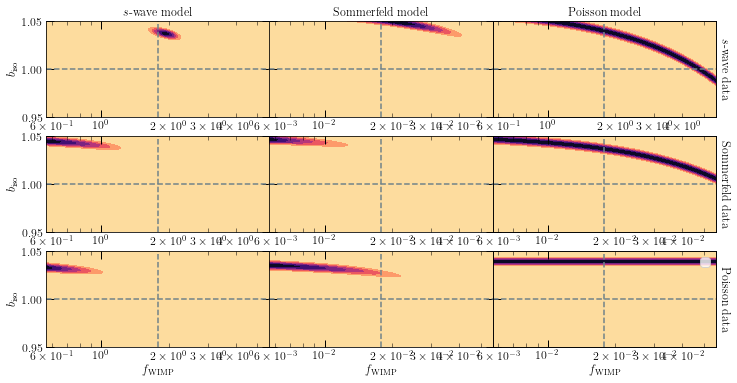

In [11]:
fig, axss = plt.subplots(ncols=3, nrows=3, figsize=(12, 6), sharey=True, gridspec_kw={'wspace': 0})
i = 0
lw = 5
zorder = 1
# p['fwimp'] *= 100
# shift_som = 1 / 0.0209

from matplotlib import cm
cmap = cm.magma_r
axs = axss[0]

for ax, s, lab in zip(axs, SS[0], ['s-wave L', 'som L', 'poisson L']):
    colors = iter(['xkcd:mulberry', 'xkcd:wheat', 'xkcd:mossy green', 'xkcd:cool blue', 'xkcd:blush pink'])
    for expdat, expo in zip(s, exposure_search):
        indmax = np.unravel_index(np.argmin(expdat, axis=None), expdat.shape)
        if lab == 'som L':
            ax.contourf(fwimps / 100, begs, np.exp(-0.5*(expdat - expdat.min())), label=f'{expo:.2}cm2s', cmap=cmap)
            ax.axvline(p['fwimp']/100, ls='--', color='xkcd:steel gray')
            ax.axhline(1, ls='--', color='xkcd:steel gray')
#             ax.plot(fwimps[indmax[1]]/100, begs[indmax[0]], marker='*', color='xkcd:barbie pink', ms=10)
#             ax.plot(fwimps/100, expdat - expdat.min(), label=f'{expo:.2}cm2s')
#             print(lab, expdat.min(),  '\t', fwimps[np.exp(-0.5*(expdat - expdat.min())).argmax()]/100)
        else:
            ax.contourf(fwimps, begs, np.exp(-0.5*(expdat - expdat.min())), label=f'{expo:.2}cm2s', cmap=cmap)
            ax.axvline(p['fwimp'], ls='--', color='xkcd:steel gray')
            ax.axhline(1, ls='--', color='xkcd:steel gray')
#             ax.plot(fwimps[indmax[1]], begs[indmax[0]], marker='*', color='xkcd:barbie pink', ms=10)
#             ax.plot(fwimps, expdat - expdat.min(), label=f'{expo:.2}cm2s')
#             print(lab, expdat.min(),  '\t', fwimps[np.exp(-0.5*(expdat - expdat.min())).argmax()])

    ax.set_xscale('log')
    
axs = axss[1]
# p['fwimp'] /=100
for ax, s, lab in zip(axs, SS[1], ['s-wave L', 'som L', 'poisson L']):
    colors = iter(['xkcd:mulberry', 'xkcd:wheat', 'xkcd:mossy green', 'xkcd:cool blue', 'xkcd:blush pink'])
    for expdat, expo in zip(s, exposure_search):
        indmax = np.unravel_index(np.argmin(expdat, axis=None), expdat.shape)
        if lab == 'som L' or lab == 'poisson L':
            ax.contourf(fwimps / 100, begs, np.exp(-0.5*(expdat - expdat.min())), label=f'{expo:.2}cm2s', cmap=cmap)
            ax.axvline(p['fwimp'] / 100, ls='--', color='xkcd:steel gray')
            ax.axhline(1, ls='--', color='xkcd:steel gray')
#             ax.plot(fwimps[indmax[1]]/100, begs[indmax[0]], marker='*', color='xkcd:barbie pink', ms=10)
#             ax.plot(fwimps/100, expdat - expdat.min(), label=f'{expo:.2}cm2s')
#             print(lab, expdat.min(),  '\t', fwimps[np.exp(-0.5*(expdat - expdat.min())).argmax()]/100)
        else:
            ax.contourf(fwimps, begs, np.exp(-0.5*(expdat - expdat.min())), label=f'{expo:.2}cm2s', cmap=cmap)
            ax.axvline(p['fwimp'], ls='--', color='xkcd:steel gray')
            ax.axhline(1, ls='--', color='xkcd:steel gray')
#             ax.plot(fwimps[indmax[1]], begs[indmax[0]], marker='*', color='xkcd:barbie pink', ms=10)
#             ax.plot(fwimps, expdat - expdat.min(), label=f'{expo:.2}cm2s')
#             print(lab, expdat.min(),  '\t', fwimps[np.exp(-0.5*(expdat - expdat.min())).argmax()])

    ax.set_xscale('log')
    
axs = axss[2]
# p['fwimp'] /=100
for ax, s, lab in zip(axs, SS[2], ['s-wave L', 'som L', 'poisson L']):
    colors = iter(['xkcd:mulberry', 'xkcd:wheat', 'xkcd:mossy green', 'xkcd:cool blue', 'xkcd:blush pink'])
    for expdat, expo in zip(s, exposure_search):
        indmax = np.unravel_index(np.argmin(expdat, axis=None), expdat.shape)
        if lab == 'som L' or lab == 'poisson L':
            ax.contourf(fwimps / 100, begs, np.exp(-0.5*(expdat - expdat.min())), label=f'{expo:.2}cm2s', cmap=cmap)
            ax.axvline(p['fwimp'] / 100, ls='--', color='xkcd:steel gray')
            ax.axhline(1, ls='--', color='xkcd:steel gray')
#             ax.plot(fwimps[indmax[1]]/100, begs[indmax[0]], marker='*', color='xkcd:barbie pink', ms=10)
#             ax.plot(fwimps/100, expdat - expdat.min(), label=f'{expo:.2}cm2s')
#             print(lab, expdat.min(),  '\t', fwimps[np.exp(-0.5*(expdat - expdat.min())).argmax()]/100)
        else:
            ax.contourf(fwimps, begs, np.exp(-0.5*(expdat - expdat.min())), label=f'{expo:.2}cm2s', cmap=cmap)
            ax.axvline(p['fwimp'], ls='--', color='xkcd:steel gray')
            ax.axhline(1, ls='--', color='xkcd:steel gray')
#             ax.plot(fwimps[indmax[1]], begs[indmax[0]], marker='*', color='xkcd:barbie pink', ms=10)
#             ax.plot(fwimps, expdat - expdat.min(), label=f'{expo:.2}cm2s')
#             print(lab, expdat.min(),  '\t', fwimps[np.exp(-0.5*(expdat - expdat.min())).argmax()])

    ax.set_xscale('log')
# p['fwimp'] *= 100 
for ax in axss[-1]:
    ax.set_xlabel(r'$f_\mathrm{WIMP}$')
    
axss[0, 0].set_ylabel(r'$b_\mathrm{iso}$')
axss[1, 0].set_ylabel(r'$b_\mathrm{iso}$')
axss[2, 0].set_ylabel(r'$b_\mathrm{iso}$')

ax = axss[0, -1].twinx()
ax.set_ylabel('$s$-wave data', rotation=270, labelpad=15)
ax.tick_params(axis='y', right=False, labelright=False)

ax = axss[1, -1].twinx()
ax.set_ylabel('Sommerfeld data', rotation=270, labelpad=15)
ax.tick_params(axis='y', right=False, labelright=False)

ax = axss[2, -1].twinx()
ax.set_ylabel('Poisson data', rotation=270, labelpad=15)
ax.tick_params(axis='y', right=False, labelright=False)

axss[0, 0].set_title(r'$s$-wave model')
axss[0, 1].set_title('Sommerfeld model')
axss[0, 2].set_title('Poisson model')
    
axss.flatten()[-1].legend()
#     ax.set_yscale('log')
#     ax.set_ylim(bottom=0, top=10)
print(p['fwimp'])
fig.savefig('./output/plots/llhds_2d_fermiexposure_bad_bg.pdf')

Add:
- Float beg but fix bg to 0.97
- Float beg w/ same bg
- Generate w/ no DM signal and fit s/som/poi (null test)
- Add to overleaf
- 

-2476.886573073396


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


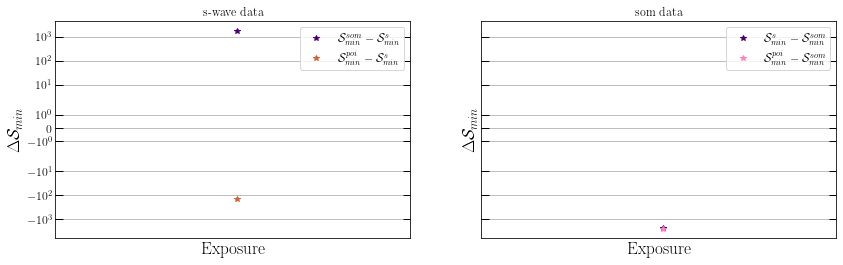

In [12]:
fig, axs = plt.subplots(ncols=2, figsize=(14,4), sharey=True, sharex=True)

ax = axs[0]
s_S, som_S, poisson_S = SS[0]
max_swave = np.amin(s_S)
max_som = np.amin(som_S)
max_poi = np.amin(poisson_S)
ax.plot(exposure_search, -max_swave + max_som, ls='', marker='*', color='xkcd:royal purple', label=r'$\mathcal{S}_{min}^{som} - \mathcal{S}_{min}^{s}$')
ax.plot(exposure_search, -max_swave + max_poi, ls='', marker='*', color='xkcd:terra cotta', label=r'$\mathcal{S}_{min}^{poi} - \mathcal{S}_{min}^{s}$')
# ax.plot(exposure_search, max_som - max_poi, ls='', marker='*', color='xkcd:pink', label=r'$\mathcal{S}_{min}^{som} - \mathcal{S}_{min}^{poi}$')
ax.set_xscale('symlog')
ax.set_yscale('symlog')
ax.grid()
# ax.set_ylim(bottom=10)
ax.set_ylabel(r'$\Delta\mathcal{S}_{min}$', fontsize='x-large')
ax.set_xlabel(r'Exposure', fontsize='x-large')
ax.legend()
 
ax = axs[1]
s_S, som_S, poisson_S = SS[1]
max_swave = np.amin(s_S)
max_som = np.amin(som_S)
max_poi = np.amin(poisson_S)
ax.plot(exposure_search, max_swave - max_som, ls='', marker='*', color='xkcd:royal purple', label=r'$\mathcal{S}_{min}^{s} - \mathcal{S}_{min}^{som}$')
# ax.plot(exposure_search, max_swave - max_poi, ls='', marker='*', color='xkcd:terra cotta', label=r'$\mathcal{S}_{min}^{s} - \mathcal{S}_{min}^{poi}$')
ax.plot(exposure_search, - max_som + max_poi, ls='', marker='*', color='xkcd:pink', label=r'$\mathcal{S}_{min}^{poi} - \mathcal{S}_{min}^{som}$')
ax.set_xscale('symlog')
ax.set_yscale('symlog')
ax.grid()
# ax.set_ylim(bottom=10)
ax.set_ylabel(r'$\Delta\mathcal{S}_{min}$', fontsize='x-large')
ax.set_xlabel(r'Exposure', fontsize='x-large')
ax.legend()
print(max_poi - max_som)
axs[0].set_title('s-wave data')
axs[1].set_title('som data')

fig.savefig('./output/deltaS_2d.pdf')

NameError: name 'mean' is not defined

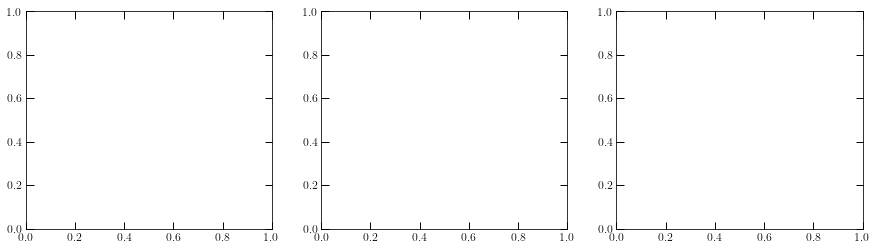

In [13]:
fig, axs = plt.subplots(ncols=3, figsize=(15,4))
axs[0].plot(exposure_search, mean, label='mean', marker='o', ms=10)
axs[0].set_title('mean counts')
axs[1].plot(exposure_search, meanpc, label='P(C) mean', marker='o', ms=10)
axs[1].set_title('mean P(C)')
axs[2].plot(exposure_search, total, label='P(C) mean', marker='o', ms=10)
axs[2].set_title('total counts')

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
# ax.set_ylim(bottom=0, top=)
ax.set_yscale('log')
ax.set_ylabel('Exposure [cm2 s]')
ax.set_xscale('log')
ax.set_xlabel('fwimp')
pc = ax.pcolormesh(fwimps, exposure_search, np.log10(s_S), cmap=cm.jet, shading='auto')
fig.colorbar(pc, label='S for s-wave');

In [ ]:
max_swave = np.amin(s_S, axis=-1)
max_som = np.amin(som_S, axis=-1)
max_poi = np.amin(poisson_S, axis=-1)